## 1. Import Librerie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Configurazione per grafici più grandi e leggibili
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✅ Librerie importate con successo")

✅ Librerie importate con successo


## 2. Caricamento Dati

In [2]:
# Carica il file CSV
filename = 'accel_data_20251120_123743.csv'

df = pd.read_csv(filename)

# Mostra le prime righe
print(f"📊 Dataset caricato: {len(df)} campioni")
print(f"⏱️  Durata: {df['Timestamp'].max() - df['Timestamp'].min():.2f} secondi")
print(f"📈 Frequenza di campionamento: ~{len(df)/(df['Timestamp'].max() - df['Timestamp'].min()):.1f} Hz\n")

df.head(10)

📊 Dataset caricato: 1004 campioni
⏱️  Durata: 19.92 secondi
📈 Frequenza di campionamento: ~50.4 Hz



,Timestamp,X (g),Y (g),Z (g),Magnitude (g)
0,17.102,-0.031250,0.953125,-0.062500,0.955683
1,17.104,-0.046875,0.953125,-0.062500,0.956321
2,17.106,-0.046875,0.953125,-0.062500,0.956321
3,17.110,-0.031250,0.953125,-0.046875,0.954789
4,17.140,-0.046875,0.953125,-0.046875,0.955428
5,17.141,-0.046875,0.953125,-0.046875,0.955428
6,17.222,-0.031250,0.953125,-0.046875,0.954789
7,17.228,-0.046875,0.953125,-0.062500,0.956321
8,17.258,-0.046875,0.953125,-0.062500,0.956321
9,17.260,-0.046875,0.953125,-0.046875,0.955428


## 3. Visualizzazione Dati Grezzi

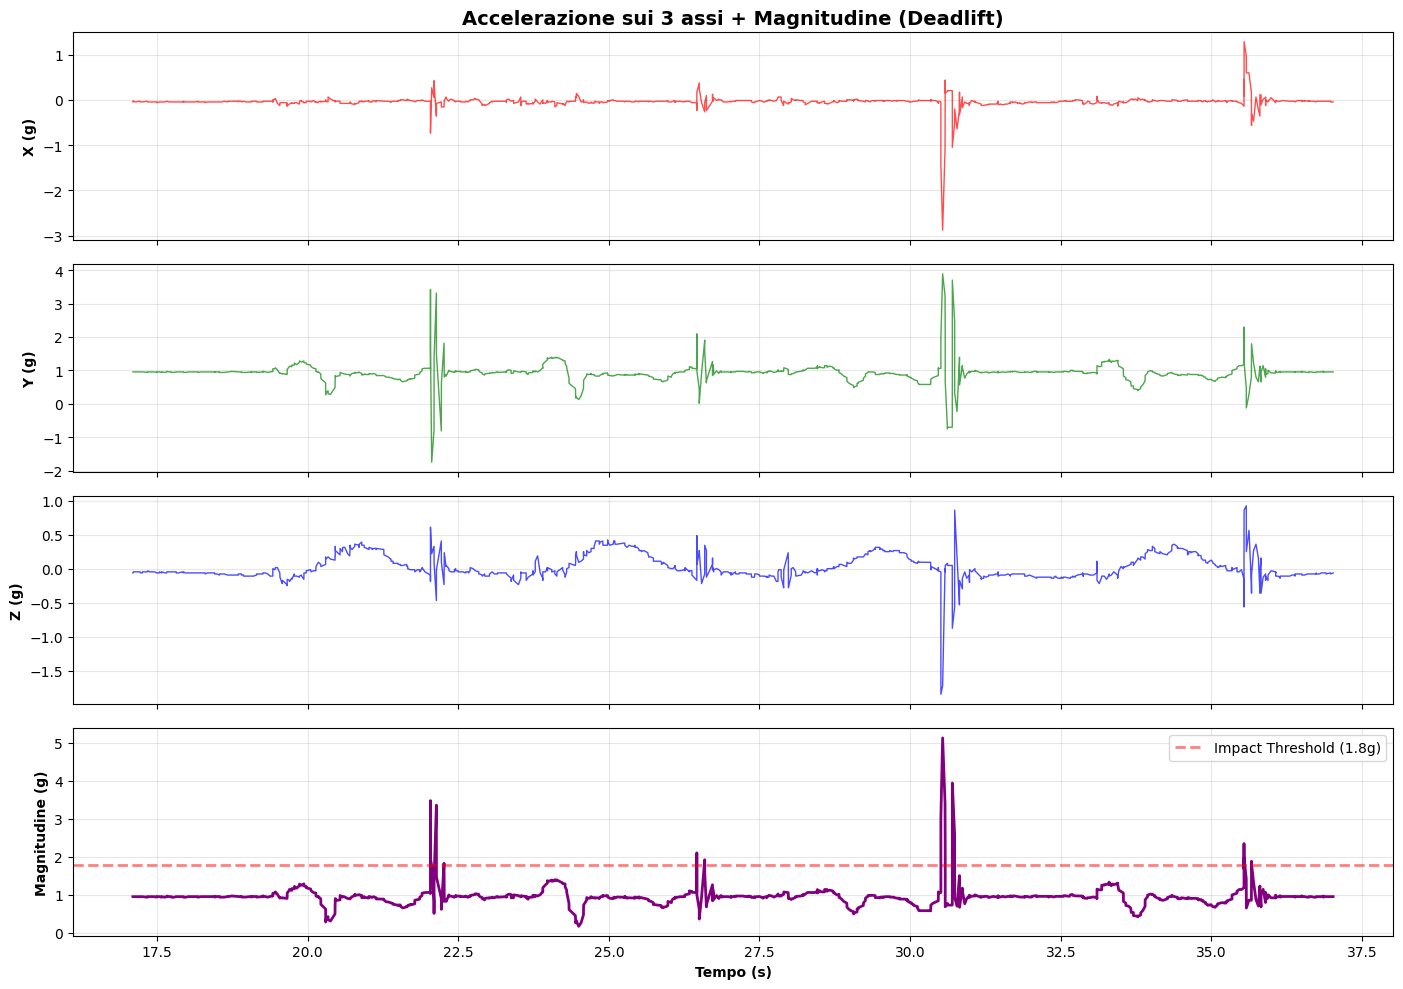

In [3]:
# Plot dei dati grezzi
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

axes[0].plot(df['Timestamp'], df['X (g)'], 'r-', alpha=0.7, linewidth=1)
axes[0].set_ylabel('X (g)', fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Accelerazione sui 3 assi + Magnitudine (Deadlift)', fontsize=14, fontweight='bold')

axes[1].plot(df['Timestamp'], df['Y (g)'], 'g-', alpha=0.7, linewidth=1)
axes[1].set_ylabel('Y (g)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

axes[2].plot(df['Timestamp'], df['Z (g)'], 'b-', alpha=0.7, linewidth=1)
axes[2].set_ylabel('Z (g)', fontweight='bold')
axes[2].grid(True, alpha=0.3)

axes[3].plot(df['Timestamp'], df['Magnitude (g)'], 'purple', linewidth=2)
axes[3].set_ylabel('Magnitudine (g)', fontweight='bold')
axes[3].set_xlabel('Tempo (s)', fontweight='bold')
axes[3].grid(True, alpha=0.3)

# Soglia impatto per riferimento visivo
axes[3].axhline(y=1.8, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Impact Threshold (1.8g)')
axes[3].legend()

plt.tight_layout()
plt.show()

## 4. Smoothing e Preprocessing

In [4]:
# Applica smoothing gaussiano per ridurre il rumore
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

sigma = 2  # Parametro di smoothing

df['X_smooth'] = gaussian_filter1d(df['X (g)'], sigma=sigma)
df['Y_smooth'] = gaussian_filter1d(df['Y (g)'], sigma=sigma)
df['Z_smooth'] = gaussian_filter1d(df['Z (g)'], sigma=sigma)
df['Mag_smooth'] = gaussian_filter1d(df['Magnitude (g)'], sigma=sigma)

# Calcola la derivata (velocità) della magnitudine per identificare cambiamenti
df['Mag_velocity'] = np.gradient(df['Mag_smooth'], df['Timestamp'])
df['Mag_velocity_smooth'] = gaussian_filter1d(df['Mag_velocity'], sigma=sigma)

print("✅ Smoothing applicato")

✅ Smoothing applicato


## 5. Rilevamento Fasi del Deadlift

L'algoritmo identifica l'**inizio** di ogni fase del deadlift:
1. **Baseline Floor** - Bilanciere a riposo sul pavimento (baseline ~0.955g)
2. **Concentric Pull** - Inizio dello stacco esplosivo (magnitudine sale sopra baseline)
3. **Lockout** - Picco del movimento (massima magnitudine della fase concentrica)
4. **Eccentric Descent** - Inizio abbassamento controllato (magnitudine scende)
5. **Impact Event** - Contatto bilanciere-pavimento (spike >1.8g)
6. **Return to Floor** - Stabilizzazione dopo le oscillazioni

⚠️ **DIFFERENZA CHIAVE con lo Squat**: Nel deadlift NON c'è fase eccentrica iniziale. Il movimento parte DIRETTAMENTE con la fase concentrica (pull dal pavimento).

In [5]:
# Analisi Magnitude con Soglie intorno alla Baseline Floor
# Baseline nel deadlift = bilanciere a riposo sul pavimento (~0.955g)

mag = df['Mag_smooth'].values
timestamps = df['Timestamp'].values

print("🔍 ANALISI MAGNITUDE DEADLIFT CON SOGLIE BASELINE")
print("=" * 80)

# Calcola baseline dai primi campioni stabili (primi 20%)
baseline_samples = int(len(mag) * 0.2)
baseline_value = np.median(mag[:baseline_samples])

# Soglie più strette per deadlift (bilanciere stabile sul pavimento)
threshold_percent = 0.05  # 5% della baseline
upper_threshold = baseline_value + (baseline_value * threshold_percent)
lower_threshold = baseline_value - (baseline_value * threshold_percent)

# Soglia impatto - molto più alta per rilevare contatti violenti
IMPACT_THRESHOLD = 1.8  # g - spike caratteristici 2-5g

print(f"📊 Baseline Floor: {baseline_value:.3f}g (bilanciere a riposo)")
print(f"📊 Soglia superiore (+5%): {upper_threshold:.3f}g (inizio pull)")
print(f"📊 Soglia inferiore (-5%): {lower_threshold:.3f}g")
print(f"💥 Soglia impatto: {IMPACT_THRESHOLD:.3f}g (bar hits floor)")

# Trova quando le soglie vengono rotte
upper_breaks = np.where(mag > upper_threshold)[0]
lower_breaks = np.where(mag < lower_threshold)[0]
impact_events = np.where(mag > IMPACT_THRESHOLD)[0]

print(f"\n🟢 Soglia superiore rotta in {len(upper_breaks)} punti (concentric pulls)")
if len(upper_breaks) > 0:
    print(f"   Primo break: t={timestamps[upper_breaks[0]]:.2f}s (Mag={mag[upper_breaks[0]]:.3f}g)")
    print(f"   Ultimo break: t={timestamps[upper_breaks[-1]]:.2f}s (Mag={mag[upper_breaks[-1]]:.3f}g)")

print(f"\n🔵 Soglia inferiore rotta in {len(lower_breaks)} punti")
if len(lower_breaks) > 0:
    print(f"   Primo break: t={timestamps[lower_breaks[0]]:.2f}s (Mag={mag[lower_breaks[0]]:.3f}g)")
    print(f"   Ultimo break: t={timestamps[lower_breaks[-1]]:.2f}s (Mag={mag[lower_breaks[-1]]:.3f}g)")

print(f"\n💥 Eventi di impatto rilevati: {len(impact_events)} punti (spikes >{IMPACT_THRESHOLD}g)")
if len(impact_events) > 0:
    # Raggruppa eventi consecutivi (oscillazioni post-impatto)
    impact_groups = []
    current_group = [impact_events[0]]
    for i in range(1, len(impact_events)):
        if impact_events[i] - impact_events[i-1] < 10:  # Entro 10 samples = stesso impatto
            current_group.append(impact_events[i])
        else:
            impact_groups.append(current_group)
            current_group = [impact_events[i]]
    impact_groups.append(current_group)
    
    print(f"   Impatti distinti: {len(impact_groups)}")
    for i, group in enumerate(impact_groups):
        max_spike_idx = group[np.argmax(mag[group])]
        print(f"   Impatto {i+1}: t={timestamps[max_spike_idx]:.2f}s, Max spike={mag[max_spike_idx]:.3f}g, Samples={len(group)}")

print("=" * 80)

🔍 ANALISI MAGNITUDE DEADLIFT CON SOGLIE BASELINE
📊 Baseline Floor: 0.954g (bilanciere a riposo)
📊 Soglia superiore (+5%): 1.002g (inizio pull)
📊 Soglia inferiore (-5%): 0.907g
💥 Soglia impatto: 1.800g (bar hits floor)

🟢 Soglia superiore rotta in 197 punti (concentric pulls)
   Primo break: t=19.42s (Mag=1.009g)
   Ultimo break: t=35.78s (Mag=1.040g)

🔵 Soglia inferiore rotta in 204 punti
   Primo break: t=20.18s (Mag=0.886g)
   Ultimo break: t=35.34s (Mag=0.886g)

💥 Eventi di impatto rilevati: 10 punti (spikes >1.8g)
   Impatti distinti: 3
   Impatto 1: t=22.04s, Max spike=2.137g, Samples=4
   Impatto 2: t=30.54s, Max spike=2.724g, Samples=5
   Impatto 3: t=35.54s, Max spike=1.808g, Samples=1


## 6. Visualizzazione con Marker delle Fasi

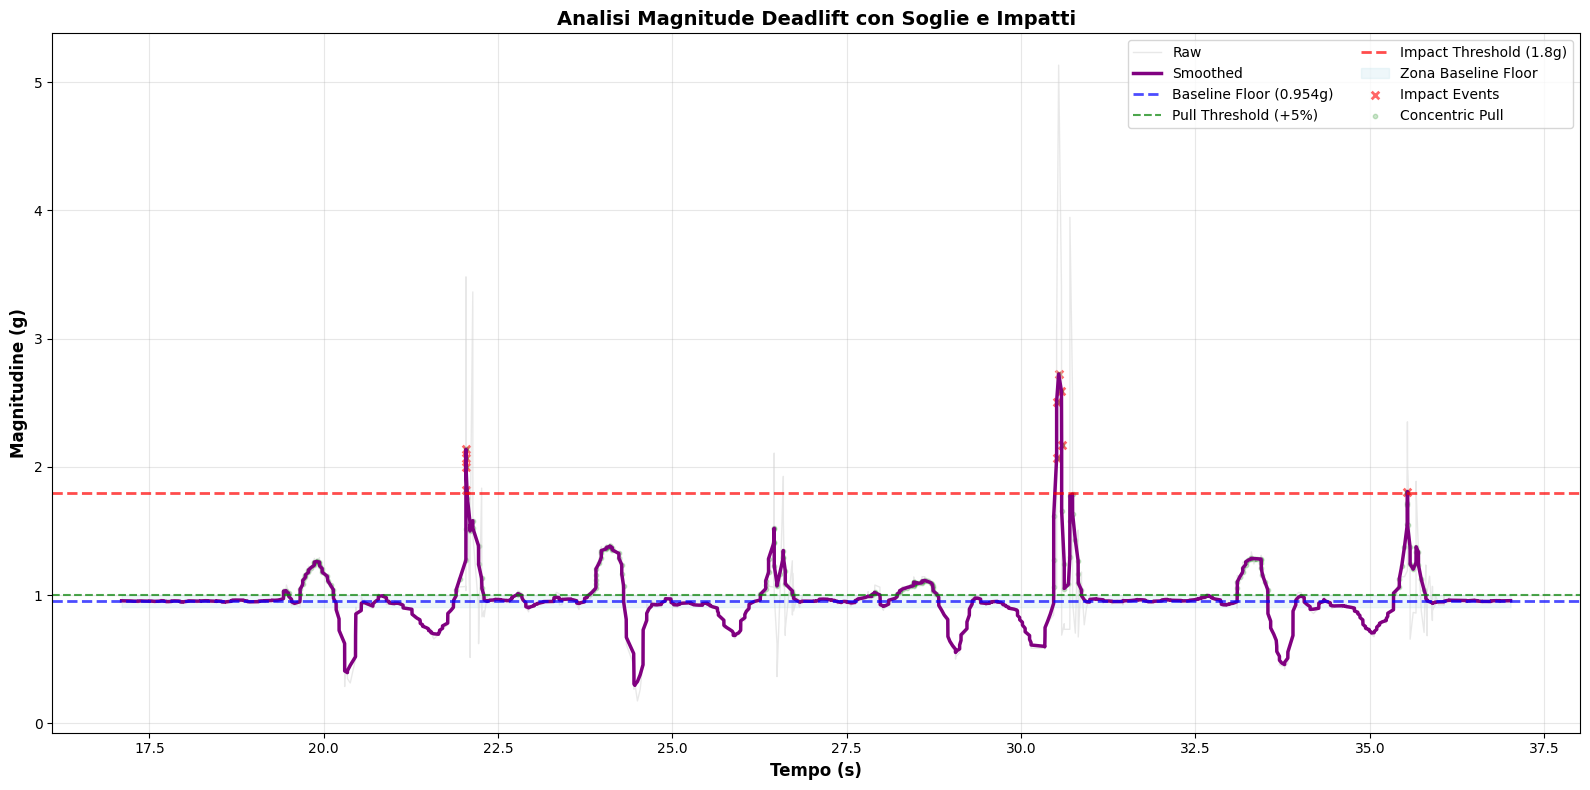

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))

# Plot magnitudine
ax.plot(df['Timestamp'], df['Magnitude (g)'], 'lightgray', alpha=0.5, linewidth=1, label='Raw')
ax.plot(df['Timestamp'], df['Mag_smooth'], 'purple', linewidth=2.5, label='Smoothed')

# Linee delle soglie
ax.axhline(y=baseline_value, color='blue', linestyle='--', linewidth=2, label=f'Baseline Floor ({baseline_value:.3f}g)', alpha=0.7)
ax.axhline(y=upper_threshold, color='green', linestyle='--', linewidth=1.5, label=f'Pull Threshold (+5%)', alpha=0.7)
ax.axhline(y=IMPACT_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Impact Threshold ({IMPACT_THRESHOLD}g)', alpha=0.7)

# Zona baseline (fill between)
ax.fill_between(df['Timestamp'], lower_threshold, upper_threshold, color='lightblue', alpha=0.2, label='Zona Baseline Floor')

# Evidenzia eventi di impatto
if len(impact_events) > 0:
    ax.scatter(timestamps[impact_events], mag[impact_events], color='red', s=30, alpha=0.6, label='Impact Events', marker='x', linewidths=2)

# Evidenzia concentric pulls
if len(upper_breaks) > 0:
    ax.scatter(timestamps[upper_breaks], mag[upper_breaks], color='green', s=10, alpha=0.2, label='Concentric Pull')

ax.set_xlabel('Tempo (s)', fontweight='bold', fontsize=12)
ax.set_ylabel('Magnitudine (g)', fontweight='bold', fontsize=12)
ax.set_title('Analisi Magnitude Deadlift con Soglie e Impatti', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=10, ncol=2)

plt.tight_layout()
plt.show()

## 7. Rilevamento Ripetizioni Deadlift con Pattern Matching

Algoritmo basato su **sequenze di picchi caratteristiche del deadlift**:

**FASE CONCENTRICA (pull dal pavimento)** ← qui calcoliamo VBT:
- Pattern: FLOOR_BASE → PULL_UP (mag sale sopra baseline) → LOCKOUT (picco) → DESCENT (mag scende)

**FASE ECCENTRICA + IMPATTO**:
- Pattern: DESCENT → IMPACT_SPIKE (>1.8g) → OSCILLATIONS → FLOOR_BASE

⚠️ **DIFFERENZA CRUCIALE**: A differenza dello squat, il deadlift **NON ha bottom detection**. Il punto di partenza è il pavimento (baseline) e la prima fase è SEMPRE concentrica (pull verso l'alto).

💥 **GESTIONE IMPATTI**: Gli spike di impatto (2-5g) vengono **esclusi** dal calcolo delle metriche VBT perché non rappresentano accelerazione prodotta dall'atleta ma forze di contatto bilanciere-pavimento.

In [7]:
"""
PATTERN MATCHING DEADLIFT con VBT (Velocity Based Training)
Rilevamento ripetizioni tramite transizioni di stato + calcolo metriche VBT avanzate
SPECIALIZZATO per movimento deadlift (concentric-first + impact detection)
"""

# Configura parametri DEADLIFT-SPECIFIC
BASELINE_ZONE = 0.05  # ±5% variazione (più stretto che squat - bilanciere stabile sul pavimento)
MIN_REP_DURATION = 1.0  # secondi (deadlift più lento dello squat)
MAX_REP_DURATION = 5.0  # secondi
REFRACTORY_PERIOD = 1.0  # secondi tra ripetizioni (più lungo per permettere reset)
IMPACT_THRESHOLD = 1.8  # g - soglia per rilevare impatti
IMPACT_SETTLE_TIME = 0.5  # secondi - tempo per stabilizzazione post-impatto
CONCENTRIC_MIN_PEAK = 1.05  # g - minimo picco concentrico per validare rep

# Calcola baseline FLOOR (non standing position!)
baseline_samples = 30
baseline_value = np.median(mag[:baseline_samples])
baseline_upper = baseline_value * (1 + BASELINE_ZONE)
baseline_lower = baseline_value * (1 - BASELINE_ZONE)

print(f"📊 DEADLIFT BASELINE ANALYSIS")
print(f"   Baseline Floor: {baseline_value:.3f}g")
print(f"   Upper threshold (+{BASELINE_ZONE*100:.0f}%): {baseline_upper:.3f}g")
print(f"   Lower threshold (-{BASELINE_ZONE*100:.0f}%): {baseline_lower:.3f}g")
print(f"   Impact threshold: {IMPACT_THRESHOLD:.3f}g")
print("=" * 90)

# Classifica samples in stati
signal_state = np.where(mag > baseline_upper, 1,  # ABOVE (pulling)
                        np.where(mag < baseline_lower, -1,  # BELOW (rare)
                                 0))  # FLOOR_BASE

# Trova transizioni di stato
state_changes = []
for i in range(1, len(signal_state)):
    if signal_state[i] != signal_state[i-1]:
        state_changes.append({
            'idx': i,
            'time': timestamps[i],
            'from_state': signal_state[i-1],
            'to_state': signal_state[i],
            'mag': mag[i]
        })

print(f"🔄 State transitions detected: {len(state_changes)}")

# Pattern Matching DEADLIFT: cerca FLOOR_BASE → PULL_UP → ritorno FLOOR_BASE
valid_reps = []
last_rep_end_time = -REFRACTORY_PERIOD

for i in range(len(state_changes) - 1):
    # Cerca inizio pull (esce da BASE verso l'alto)
    if state_changes[i]['from_state'] == 0 and state_changes[i]['to_state'] == 1:
        rep_start_idx = state_changes[i]['idx']
        rep_start_time = state_changes[i]['time']
        
        # Applica refractory period
        if rep_start_time - last_rep_end_time < REFRACTORY_PERIOD:
            continue
        
        # Cerca evento di impatto dopo il pull
        impact_idx = None
        impact_time = None
        impact_mag = None
        
        # Scansiona avanti cercando spike >IMPACT_THRESHOLD
        for k in range(rep_start_idx + 10, min(rep_start_idx + 300, len(mag))):
            if mag[k] > IMPACT_THRESHOLD:
                impact_idx = k
                impact_time = timestamps[k]
                impact_mag = mag[k]
                break
        
        if impact_idx is None:
            # Nessun impatto trovato - potrebbe essere incomplete rep
            continue
        
        # Cerca stabilizzazione dopo impatto (ritorno a baseline floor)
        rep_end_idx = None
        for k in range(impact_idx + 5, min(impact_idx + 50, len(mag))):
            # Check se torniamo in zona baseline per almeno 5 samples consecutivi
            if np.all(np.abs(mag[k:min(k+5, len(mag))] - baseline_value) < (baseline_value * BASELINE_ZONE)):
                rep_end_idx = k
                break
        
        if rep_end_idx is None:
            rep_end_idx = min(impact_idx + 30, len(mag) - 1)
        
        rep_end_time = timestamps[rep_end_idx]
        rep_duration = rep_end_time - rep_start_time
        
        # Valida durata
        if not (MIN_REP_DURATION <= rep_duration <= MAX_REP_DURATION):
            continue
        
        # Trova lockout (picco concentrico) - PRIMA dell'impatto
        concentric_segment = mag[rep_start_idx:impact_idx]
        
        if len(concentric_segment) < 10:
            continue
        
        lockout_relative = np.argmax(concentric_segment)
        lockout_idx = rep_start_idx + lockout_relative
        lockout_mag = mag[lockout_idx]
        
        # Verifica che il picco concentrico sia abbastanza alto
        if lockout_mag < CONCENTRIC_MIN_PEAK:
            continue
        
        # Salva ripetizione valida
        rep = {
            'rep_num': len(valid_reps) + 1,
            'start_idx': rep_start_idx,
            'end_idx': rep_end_idx,
            'lockout_idx': lockout_idx,
            'impact_idx': impact_idx,
            'start_time': rep_start_time,
            'end_time': rep_end_time,
            'lockout_time': timestamps[lockout_idx],
            'impact_time': impact_time,
            'duration': rep_duration,
            'mag_start': mag[rep_start_idx],
            'mag_lockout': lockout_mag,
            'mag_impact': impact_mag,
            'mag_end': mag[rep_end_idx],
            'concentric_duration': timestamps[lockout_idx] - rep_start_time,
            'eccentric_duration': impact_time - timestamps[lockout_idx]
        }
        valid_reps.append(rep)
        last_rep_end_time = rep_end_time

print(f"\n✅ Valid deadlift repetitions detected: {len(valid_reps)}")
print("=" * 90)

# CALCOLO METRICHE VBT per ogni ripetizione (SOLO fase concentrica, ESCLUDI impatti)
reps_with_metrics = []

if len(valid_reps) > 0:
    for rep in valid_reps:
        # Estrai fase concentrica (floor → lockout) - ESCLUDI impatto!
        start_idx = rep['start_idx']
        lockout_idx = rep['lockout_idx']
        
        if lockout_idx <= start_idx:
            print(f"⚠️  Rep {rep['rep_num']}: Invalid concentric phase (lockout before start)")
            continue
        
        mag_concentric = mag[start_idx:lockout_idx+1]
        time_concentric = timestamps[start_idx:lockout_idx+1]
        
        if len(mag_concentric) < 2:
            print(f"⚠️  Rep {rep['rep_num']}: Too few samples in concentric phase")
            continue
        
        # GRAVITY COMPENSATION - Sottrai baseline_value (non 1.0g!) perché partiamo dal pavimento
        mag_accel_net = (mag_concentric - baseline_value) * 9.81  # m/s²
        
        print(f"\n🔍 DEBUG Rep {rep['rep_num']}:")
        print(f"   Mag range (concentric): {mag_concentric.min():.3f}g to {mag_concentric.max():.3f}g")
        print(f"   Impact magnitude: {rep['mag_impact']:.3f}g (EXCLUDED from VBT)")
        print(f"   Accel net range: {mag_accel_net.min():.3f} to {mag_accel_net.max():.3f} m/s²")
        
        # Integrazione velocità: v(t) = v(t-1) + a(t) * dt, con v(0) = 0 al floor
        velocity = np.zeros(len(mag_accel_net))
        displacement = np.zeros(len(mag_accel_net))
        for k in range(1, len(mag_accel_net)):
            dt = time_concentric[k] - time_concentric[k-1]
            velocity[k] = velocity[k-1] + mag_accel_net[k] * dt
            displacement[k] = displacement[k-1] + velocity[k] * dt
        
        print(f"   Velocity range: {velocity.min():.3f} to {velocity.max():.3f} m/s")
        
        # Calcola propulsive mask
        propulsive_mask = mag_accel_net > 0
        
        # Metriche VBT di base
        positive_velocity = velocity[velocity > 0]
        if len(positive_velocity) > 0:
            mean_velocity = np.mean(positive_velocity)
            peak_velocity = np.max(velocity)
            if np.any(propulsive_mask):
                mean_propulsive_velocity = np.mean(velocity[propulsive_mask])
            else:
                mean_propulsive_velocity = 0.0
        else:
            mean_velocity = 0.0
            peak_velocity = 0.0
            mean_propulsive_velocity = 0.0
        
        # Time to Peak Velocity
        peak_vel_idx = np.argmax(velocity)
        time_to_peak_velocity = time_concentric[peak_vel_idx] - time_concentric[0]
        
        # ROM (Range of Motion) - displacement totale
        concentric_displacement = displacement[-1]
        
        # Calcolo potenza (P = m * a * v)
        MASS = 1.0  # kg (placeholder - da sostituire con massa reale)
        power = MASS * mag_accel_net * velocity  # Watt
        mean_power = np.mean(power[power > 0]) if np.any(power > 0) else 0.0
        peak_power = np.max(power)
        
        if np.any(propulsive_mask):
            mean_propulsive_power = np.mean(power[propulsive_mask])
        else:
            mean_propulsive_power = 0.0
        
        # Salva tutte le metriche
        rep['mean_velocity'] = mean_velocity
        rep['peak_velocity'] = peak_velocity
        rep['mean_propulsive_velocity'] = mean_propulsive_velocity
        rep['time_to_peak_velocity'] = time_to_peak_velocity
        rep['concentric_displacement'] = concentric_displacement
        rep['mean_power'] = mean_power
        rep['peak_power'] = peak_power
        rep['mean_propulsive_power'] = mean_propulsive_power
        rep['time_under_tension'] = rep['duration']
        
        reps_with_metrics.append(rep)
        
        print(f"\n📊 REP #{rep['rep_num']}")
        print(f"   ⏱️  Sequenza: FLOOR {rep['start_time']:.2f}s → LOCKOUT {rep['lockout_time']:.2f}s → IMPACT {rep['impact_time']:.2f}s → FLOOR {rep['end_time']:.2f}s")
        print(f"   ⏱️  Durate: TUT={rep['time_under_tension']:.2f}s | Conc={rep['concentric_duration']:.2f}s | Ecc={rep['eccentric_duration']:.2f}s")
        print(f"   📈 Magnitudine: {rep['mag_start']:.3f}g → {rep['mag_lockout']:.3f}g → 💥{rep['mag_impact']:.3f}g → {rep['mag_end']:.3f}g")
        print(f"   🚀 Mean Velocity: {rep['mean_velocity']:.3f} m/s | MPV: {rep['mean_propulsive_velocity']:.3f} m/s")
        print(f"   ⚡ Peak Velocity: {rep['peak_velocity']:.3f} m/s | Time to Peak: {rep['time_to_peak_velocity']:.3f}s")
        print(f"   💪 Mean Power: {rep['mean_power']:.2f} W | Peak Power: {rep['peak_power']:.2f} W | MPP: {rep['mean_propulsive_power']:.2f} W")
        print(f"   📏 ROM (Concentric): {rep['concentric_displacement']:.3f} m")
    
    print("=" * 90)
    
    valid_reps = reps_with_metrics
    
    # Statistiche aggregate e Velocity Loss
    if len(valid_reps) > 1:
        mean_vels = [r['mean_velocity'] for r in valid_reps]
        peak_vels = [r['peak_velocity'] for r in valid_reps]
        mpvs = [r['mean_propulsive_velocity'] for r in valid_reps]
        mean_powers = [r['mean_power'] for r in valid_reps]
        peak_powers = [r['peak_power'] for r in valid_reps]
        roms = [r['concentric_displacement'] for r in valid_reps]
        tuts = [r['time_under_tension'] for r in valid_reps]
        impact_mags = [r['mag_impact'] for r in valid_reps]
        
        velocity_loss_percent = ((mean_vels[0] - mean_vels[-1]) / mean_vels[0]) * 100 if mean_vels[0] > 0 else 0.0
        
        print(f"\n📈 STATISTICHE AGGREGATE DEADLIFT ({len(valid_reps)} ripetizioni)")
        print(f"   Mean Velocity: {np.mean(mean_vels):.3f} m/s (±{np.std(mean_vels):.3f})")
        print(f"   Peak Velocity: {np.mean(peak_vels):.3f} m/s (±{np.std(peak_vels):.3f})")
        print(f"   Mean Propulsive Velocity: {np.mean(mpvs):.3f} m/s (±{np.std(mpvs):.3f})")
        print(f"   Mean Power: {np.mean(mean_powers):.2f} W (±{np.std(mean_powers):.2f})")
        print(f"   Peak Power: {np.mean(peak_powers):.2f} W (±{np.std(peak_powers):.2f})")
        print(f"   ROM (Concentric): {np.mean(roms):.3f} m (±{np.std(roms):.3f})")
        print(f"   Time Under Tension: {np.mean(tuts):.2f}s (±{np.std(tuts):.2f})")
        print(f"   💥 Impact Magnitude: {np.mean(impact_mags):.2f}g (±{np.std(impact_mags):.2f}) [range: {np.min(impact_mags):.2f}-{np.max(impact_mags):.2f}g]")
        print(f"\n📉 VELOCITY LOSS: {velocity_loss_percent:.1f}% (Rep 1 → Rep {len(valid_reps)})")
        if velocity_loss_percent > 20:
            print(f"   ⚠️  Alta fatica rilevata (VL > 20%)")
        elif velocity_loss_percent > 10:
            print(f"   ⚡ Fatica moderata (VL 10-20%)")
        else:
            print(f"   ✅ Fatica minima (VL < 10%)")
        
        # Analisi impatti
        print(f"\n💥 ANALISI IMPATTI:")
        if np.max(impact_mags) > 4.0:
            print(f"   ⚠️  ATTENZIONE: Impatti molto violenti rilevati (>4g)")
            print(f"   Considerare migliorare il controllo eccentrico per proteggere bilanciere e pavimento")
        elif np.max(impact_mags) > 3.0:
            print(f"   ⚡ Impatti forti (3-4g) - controllare discesa se possibile")
        else:
            print(f"   ✅ Impatti moderati (<3g) - buon controllo eccentrico")
        
        print("=" * 90)
else:
    print("⚠️ Nessuna ripetizione valida rilevata")

📊 DEADLIFT BASELINE ANALYSIS
   Baseline Floor: 0.954g
   Upper threshold (+5%): 1.002g
   Lower threshold (-5%): 0.906g
   Impact threshold: 1.800g
🔄 State transitions detected: 42

✅ Valid deadlift repetitions detected: 3

🔍 DEBUG Rep 1:
   Mag range (concentric): 0.395g to 1.518g
   Impact magnitude: 1.820g (EXCLUDED from VBT)
   Accel net range: -5.480 to 5.535 m/s²
   Velocity range: -1.267 to 1.032 m/s

📊 REP #1
   ⏱️  Sequenza: FLOOR 19.42s → LOCKOUT 22.04s → IMPACT 22.04s → FLOOR 22.30s
   ⏱️  Durate: TUT=2.87s | Conc=2.62s | Ecc=0.00s
   📈 Magnitudine: 1.009g → 1.518g → 💥1.820g → 0.996g
   🚀 Mean Velocity: 0.485 m/s | MPV: 0.129 m/s
   ⚡ Peak Velocity: 1.032 m/s | Time to Peak: 0.716s
   💪 Mean Power: 0.72 W | Peak Power: 2.44 W | MPP: 0.31 W
   📏 ROM (Concentric): -0.296 m

🔍 DEBUG Rep 2:
   Mag range (concentric): 0.552g to 1.614g
   Impact magnitude: 2.071g (EXCLUDED from VBT)
   Accel net range: -3.940 to 6.477 m/s²
   Velocity range: -0.626 to 1.750 m/s

📊 REP #2
   ⏱️  S

## 8. Visualizzazione Ripetizioni Deadlift con VBT

C:\Users\Admin\AppData\Local\Temp\ipykernel_28280\2320979378.py:111: UserWarning: Glyph 128165 (\N{COLLISION SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\dev\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128165 (\N{COLLISION SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\dev\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128165 (\N{COLLISION SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


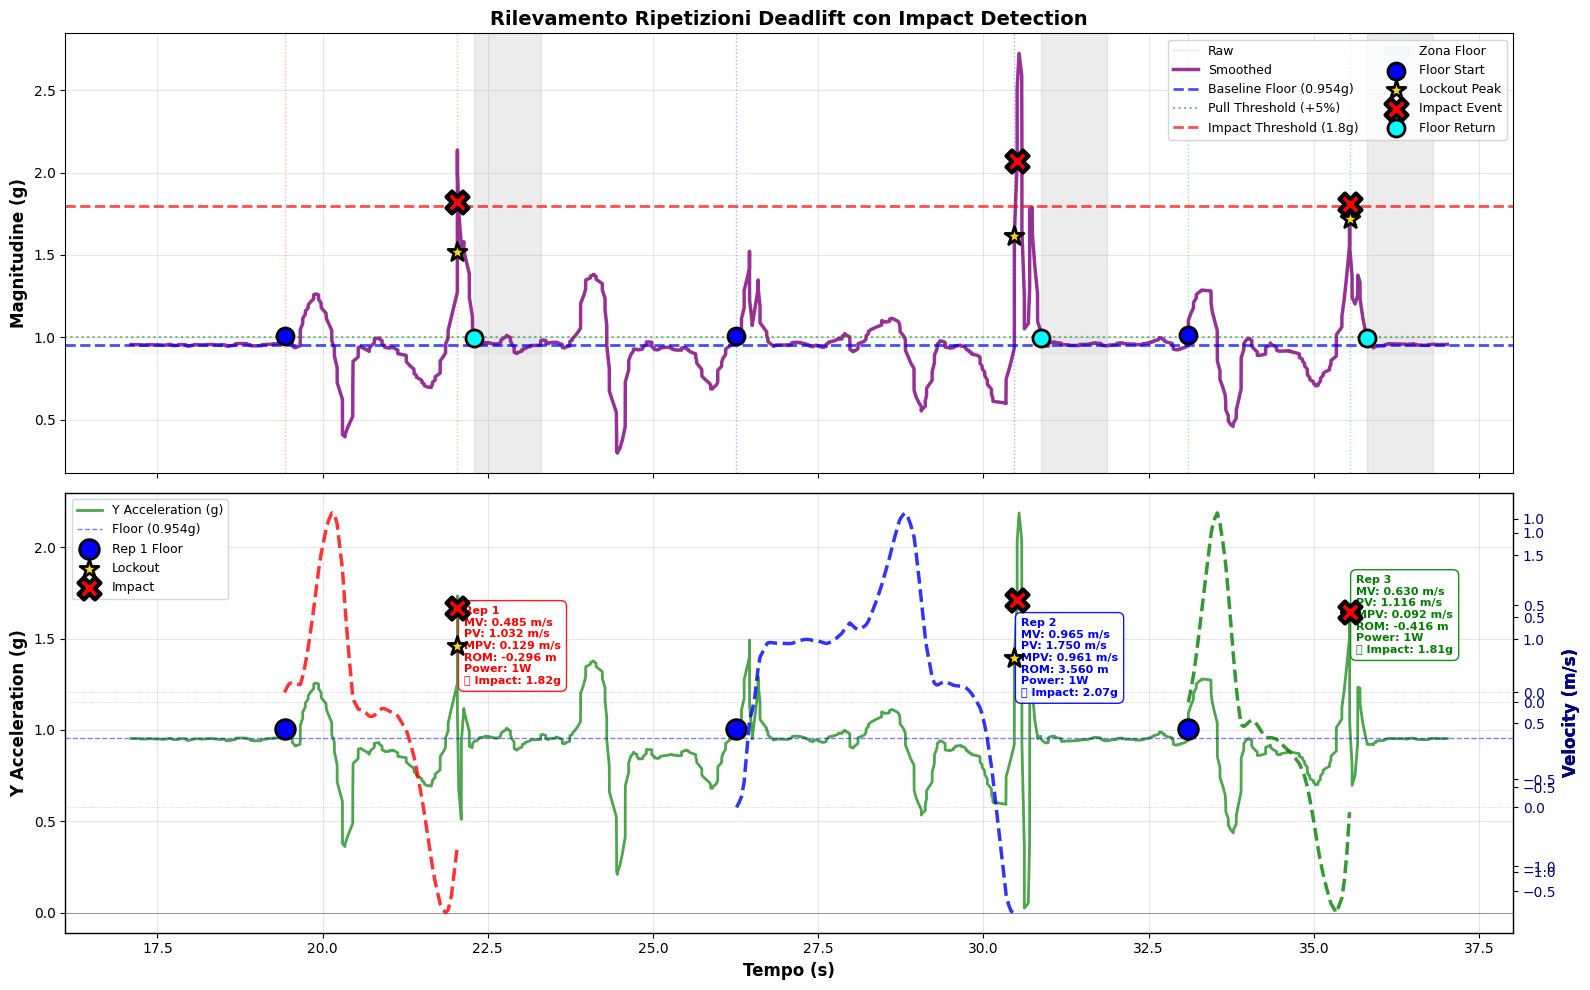

✅ Visualizzazione completata


In [8]:
if len(valid_reps) > 0:
    # Estrai Y acceleration smoothed per il plot
    y_acc = df['Y_smooth'].values
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
    
    # SUBPLOT 1: Magnitudine con marker delle fasi DEADLIFT
    ax1 = axes[0]
    ax1.plot(timestamps, mag, 'lightgray', alpha=0.5, linewidth=1, label='Raw')
    ax1.plot(timestamps, mag, 'purple', linewidth=2.5, label='Smoothed', alpha=0.8)
    
    # Zone baseline floor
    ax1.axhline(y=baseline_value, color='blue', linestyle='--', linewidth=2, label=f'Baseline Floor ({baseline_value:.3f}g)', alpha=0.7)
    ax1.axhline(y=baseline_upper, color='green', linestyle=':', linewidth=1.5, label=f'Pull Threshold (+{BASELINE_ZONE*100:.0f}%)', alpha=0.5)
    ax1.axhline(y=IMPACT_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Impact Threshold ({IMPACT_THRESHOLD}g)', alpha=0.7)
    ax1.fill_between(timestamps, baseline_lower, baseline_upper, color='lightblue', alpha=0.1, label='Zona Floor')
    
    # Marker per ogni ripetizione
    colors_rep = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']
    for i, rep in enumerate(valid_reps):
        color = colors_rep[i % len(colors_rep)]
        
        # Floor Start, Lockout, Impact, Floor End
        ax1.scatter(rep['start_time'], rep['mag_start'], s=150, marker='o', color='blue', 
                   edgecolors='black', linewidths=2, zorder=10, 
                   label='Floor Start' if i == 0 else None)
        ax1.scatter(rep['lockout_time'], rep['mag_lockout'], s=200, marker='*', color='gold', 
                   edgecolors='black', linewidths=2, zorder=10,
                   label='Lockout Peak' if i == 0 else None)
        ax1.scatter(rep['impact_time'], rep['mag_impact'], s=250, marker='X', color='red', 
                   edgecolors='black', linewidths=3, zorder=11,
                   label='Impact Event' if i == 0 else None)
        ax1.scatter(rep['end_time'], rep['mag_end'], s=150, marker='o', color='cyan', 
                   edgecolors='black', linewidths=2, zorder=10,
                   label='Floor Return' if i == 0 else None)
        
        # Linea verticale per concentric phase (floor → lockout)
        ax1.axvline(x=rep['start_time'], color=color, linestyle=':', alpha=0.3, linewidth=1)
        ax1.axvline(x=rep['lockout_time'], color=color, linestyle=':', alpha=0.3, linewidth=1)
        
        # Zona refrattaria dopo ogni rep
        refractory_end = rep['end_time'] + REFRACTORY_PERIOD
        ax1.axvspan(rep['end_time'], min(refractory_end, timestamps[-1]), 
                   color='gray', alpha=0.15, zorder=1)
    
    ax1.set_ylabel('Magnitudine (g)', fontweight='bold', fontsize=12)
    ax1.set_title('Rilevamento Ripetizioni Deadlift con Impact Detection', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right', fontsize=9, ncol=2)
    
    # SUBPLOT 2: Accelerazione Y con velocità integrata
    ax2 = axes[1]
    ax2.plot(timestamps, y_acc, 'green', linewidth=2, alpha=0.7, label='Y Acceleration (g)')
    ax2.axhline(y=baseline_value, color='blue', linestyle='--', linewidth=1, alpha=0.5, label=f'Floor ({baseline_value:.3f}g)')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
    
    # Plot velocità per ogni ripetizione (SOLO concentric phase - NO impact!)
    for i, rep in enumerate(valid_reps):
        color = colors_rep[i % len(colors_rep)]
        
        # Ricostruisci velocità per il plot usando magnitudine (floor → lockout ONLY)
        concentric_slice = slice(rep['start_idx'], rep['lockout_idx'] + 1)
        mag_concentric = mag[concentric_slice]
        time_concentric = timestamps[concentric_slice]
        mag_accel_net = (mag_concentric - baseline_value) * 9.81
        
        velocity_plot = np.zeros(len(mag_accel_net))
        for j in range(1, len(velocity_plot)):
            dt_step = time_concentric[j] - time_concentric[j-1]
            velocity_plot[j] = velocity_plot[j-1] + mag_accel_net[j] * dt_step
        
        # Plot su asse secondario
        ax2_vel = ax2.twinx()
        ax2_vel.plot(time_concentric, velocity_plot, color=color, linewidth=2.5, 
                    linestyle='--', alpha=0.8, label=f"Rep {rep['rep_num']} Velocity")
        ax2_vel.set_ylabel('Velocity (m/s)', fontweight='bold', fontsize=12, color='navy')
        ax2_vel.tick_params(axis='y', labelcolor='navy')
        ax2_vel.axhline(y=0, color='navy', linestyle=':', linewidth=0.5, alpha=0.3)
        
        # Marker floor start e lockout
        ax2.scatter(rep['start_time'], y_acc[rep['start_idx']], s=200, marker='o', 
                   color='blue', edgecolors='black', linewidths=2, zorder=10, 
                   label=f"Rep {rep['rep_num']} Floor" if i == 0 else None)
        ax2.scatter(rep['lockout_time'], y_acc[rep['lockout_idx']], s=200, marker='*', 
                   color='gold', edgecolors='black', linewidths=2, zorder=10,
                   label='Lockout' if i == 0 else None)
        ax2.scatter(rep['impact_time'], y_acc[rep['impact_idx']], s=250, marker='X', 
                   color='red', edgecolors='black', linewidths=3, zorder=11,
                   label='Impact' if i == 0 else None)
        
        # Aggiungi testo con metriche VBT vicino al lockout
        text_x = rep['lockout_time'] + 0.1
        text_y = y_acc[rep['lockout_idx']]
        metrics_text = (f"Rep {rep['rep_num']}\n"
                       f"MV: {rep['mean_velocity']:.3f} m/s\n"
                       f"PV: {rep['peak_velocity']:.3f} m/s\n"
                       f"MPV: {rep['mean_propulsive_velocity']:.3f} m/s\n"
                       f"ROM: {rep['concentric_displacement']:.3f} m\n"
                       f"Power: {rep['mean_power']:.0f}W\n"
                       f"💥 Impact: {rep['mag_impact']:.2f}g")
        ax2.text(text_x, text_y, metrics_text,
                fontsize=8, color=color, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor=color, alpha=0.9),
                verticalalignment='center')
    
    ax2.set_ylabel('Y Acceleration (g)', fontweight='bold', fontsize=12)
    ax2.set_xlabel('Tempo (s)', fontweight='bold', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper left', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualizzazione completata")
else:
    print("⚠️ Nessuna ripetizione da visualizzare")

## 9. Grafici Trend VBT - Velocity Loss e Fatigue Analysis

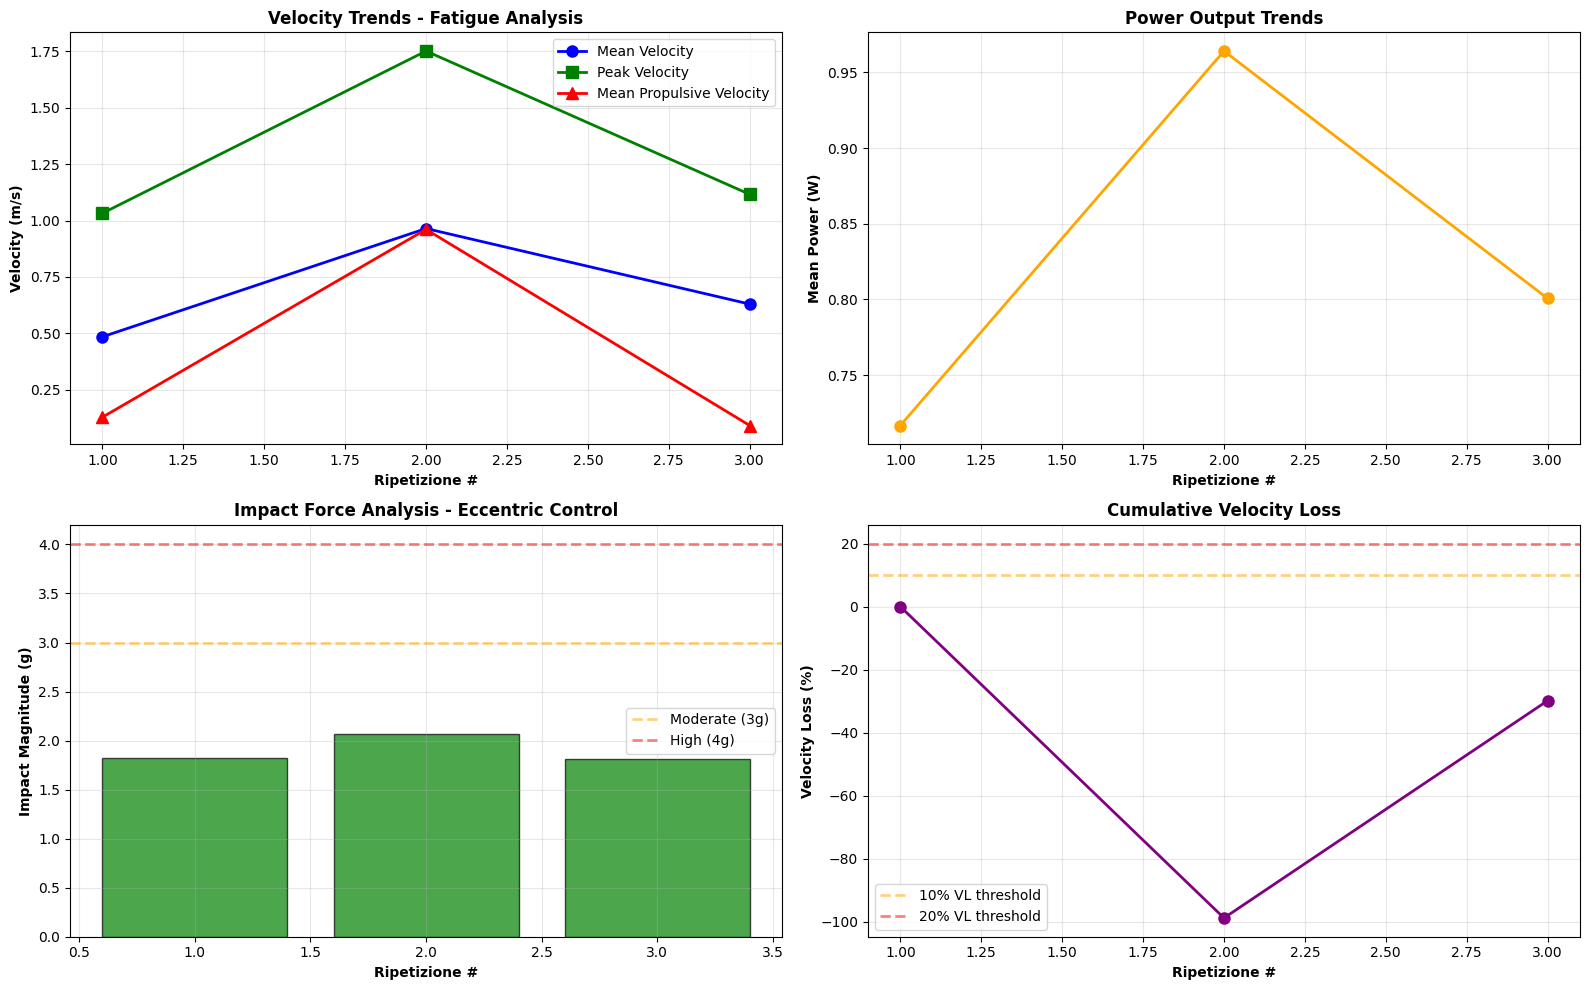

✅ Analisi trend completata


In [9]:
if len(valid_reps) > 1:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    rep_numbers = [r['rep_num'] for r in valid_reps]
    mean_vels = [r['mean_velocity'] for r in valid_reps]
    peak_vels = [r['peak_velocity'] for r in valid_reps]
    mpvs = [r['mean_propulsive_velocity'] for r in valid_reps]
    mean_powers = [r['mean_power'] for r in valid_reps]
    impact_mags = [r['mag_impact'] for r in valid_reps]
    
    # Plot 1: Velocity Trends
    ax1 = axes[0, 0]
    ax1.plot(rep_numbers, mean_vels, 'o-', color='blue', linewidth=2, markersize=8, label='Mean Velocity')
    ax1.plot(rep_numbers, peak_vels, 's-', color='green', linewidth=2, markersize=8, label='Peak Velocity')
    ax1.plot(rep_numbers, mpvs, '^-', color='red', linewidth=2, markersize=8, label='Mean Propulsive Velocity')
    ax1.set_xlabel('Ripetizione #', fontweight='bold')
    ax1.set_ylabel('Velocity (m/s)', fontweight='bold')
    ax1.set_title('Velocity Trends - Fatigue Analysis', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Power Trends
    ax2 = axes[0, 1]
    ax2.plot(rep_numbers, mean_powers, 'o-', color='orange', linewidth=2, markersize=8)
    ax2.set_xlabel('Ripetizione #', fontweight='bold')
    ax2.set_ylabel('Mean Power (W)', fontweight='bold')
    ax2.set_title('Power Output Trends', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Impact Magnitude Trends
    ax3 = axes[1, 0]
    colors_impact = ['red' if im > 4.0 else 'orange' if im > 3.0 else 'green' for im in impact_mags]
    ax3.bar(rep_numbers, impact_mags, color=colors_impact, alpha=0.7, edgecolor='black')
    ax3.axhline(y=3.0, color='orange', linestyle='--', linewidth=2, label='Moderate (3g)', alpha=0.5)
    ax3.axhline(y=4.0, color='red', linestyle='--', linewidth=2, label='High (4g)', alpha=0.5)
    ax3.set_xlabel('Ripetizione #', fontweight='bold')
    ax3.set_ylabel('Impact Magnitude (g)', fontweight='bold')
    ax3.set_title('Impact Force Analysis - Eccentric Control', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Velocity Loss Percentage
    ax4 = axes[1, 1]
    velocity_loss_per_rep = [(mean_vels[0] - mv) / mean_vels[0] * 100 for mv in mean_vels]
    ax4.plot(rep_numbers, velocity_loss_per_rep, 'o-', color='purple', linewidth=2, markersize=8)
    ax4.axhline(y=10, color='orange', linestyle='--', linewidth=2, label='10% VL threshold', alpha=0.5)
    ax4.axhline(y=20, color='red', linestyle='--', linewidth=2, label='20% VL threshold', alpha=0.5)
    ax4.set_xlabel('Ripetizione #', fontweight='bold')
    ax4.set_ylabel('Velocity Loss (%)', fontweight='bold')
    ax4.set_title('Cumulative Velocity Loss', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Analisi trend completata")
elif len(valid_reps) == 1:
    print("ℹ️  Una sola ripetizione rilevata - grafici trend richiedono almeno 2 reps")
else:
    print("⚠️ Nessuna ripetizione per generare grafici trend")

## 10. Riepilogo e Conclusioni

Questo notebook ha analizzato i dati dell'accelerometro durante l'esecuzione di **deadlift** identificando le **6 fasi** del movimento:

### Fasi Identificate:
1. 🟦 **Baseline Floor** - Bilanciere a riposo sul pavimento (~0.955g)
2. 🟢 **Concentric Pull** - Stacco esplosivo dal pavimento (magnitudine sale >1.05g)
3. 🟡 **Lockout** - Posizione finale in piedi (picco della fase concentrica)
4. 🟠 **Eccentric Descent** - Abbassamento controllato del bilanciere
5. 💥 **Impact Event** - Contatto bilanciere-pavimento (spike 2-5g)
6. 🔵 **Return to Floor** - Stabilizzazione dopo oscillazioni post-impatto

### Marker sui Grafici:
- **Cerchi blu** (●) = Floor Baseline (inizio/fine)
- **Stelle gialle** (★) = Lockout (picco concentrico)
- **Croci rosse** (✖) = Impact Event
- **Cerchi cyan** (●) = Return to Floor

### Differenze Chiave vs Squat:
❌ **NON c'è fase eccentrica iniziale** - il movimento parte SUBITO con la fase concentrica  
❌ **NON c'è "bottom position"** - il punto di partenza è il pavimento (baseline)  
✅ **C'è un evento di impatto** - spike violento quando il bilanciere tocca terra  
✅ **Baseline più bassa** - ~0.955g invece di 1.0g (bilanciere appoggiato vs persona in piedi)  
✅ **VBT calcolato SOLO sulla concentrica** - gli impatti sono esclusi dalle metriche

### Analisi Completata:
✅ Identificazione automatica delle ripetizioni con pattern concentric-first  
✅ Rilevamento preciso degli eventi di impatto (spike >1.8g)  
✅ Calcolo metriche VBT avanzate (MV, PV, MPV, Power, ROM)  
✅ Analisi del controllo eccentrico tramite magnitudine impatti  
✅ Velocity Loss monitoring per fatigue assessment  
✅ Grafici trend per monitorare performance e tecnica

### Raccomandazioni Uso:
- 💪 Monitorare **Mean Velocity** per ottimizzare carico allenamento
- ⚡ Controllare **Velocity Loss** per evitare overtraining (soglia 20%)
- 💥 Analizzare **Impact Magnitude** per migliorare controllo eccentrico
- 📏 Usare **ROM** per verificare consistenza tecnica tra ripetizioni